In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import uniform, invgamma, bernoulli, poisson, norm
import statsmodels.api as sm
import pandas as pd
from preprocessing import prepare_data, prepare_data_no_standardizing, MAR_data_deletion
from model_code import Gibbs_MH
import pymc3 as pm
import arviz as az
from statsmodels.tsa.stattools import acf 
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('student-mat.csv', sep=",")
features = ["age", "sex", "failures", "higher", "Medu", 
            "absences", "G2", "G3"]
df = df[features]
df.head()

,age,sex,failures,higher,Medu,absences,G2,G3
0,18,F,0,yes,4,6,6,6
1,17,F,0,yes,1,4,5,6
2,15,F,3,yes,1,10,8,10
3,15,F,0,yes,4,2,14,15
4,16,F,0,yes,3,4,10,10


In [5]:
X_df, y_df = prepare_data_no_standardizing(df)
X_df.head()

,age,failures,Medu,absences,G2,sex_M,higher_yes,intercept
0,18,0,4,6,6,0,1,1
1,17,0,1,4,5,0,1,1
2,15,3,1,10,8,0,1,1
3,15,0,4,2,14,0,1,1
4,16,0,3,4,10,0,1,1


In [6]:
X_df_missing = MAR_data_deletion(X_df, 0.05, 0.05, 'higher_yes', 'absences')
X_df_missing

,age,failures,Medu,absences,G2,sex_M,higher_yes,intercept
0,18,0,4,6.0,6,0,1.0,1
1,17,0,1,4.0,5,0,1.0,1
2,15,3,1,10.0,8,0,1.0,1
3,15,0,4,2.0,14,0,1.0,1
4,16,0,3,4.0,10,0,1.0,1
...,...,...,...,...,...,...,...,...
390,20,2,2,11.0,9,1,1.0,1
391,17,0,3,3.0,16,1,1.0,1
392,21,3,1,3.0,8,1,1.0,1
393,18,0,3,0.0,12,1,1.0,1


In [41]:
X = X_df_missing.to_numpy()
y = y_df.to_numpy()
B = 10000
n = len(y)
higher_yes_col = 6
absences_col = 3
age_col = 0
tau = 7

In [42]:
(betas, sigmas2, higher_yes_sim, absences_sim, alphas0, alphas1, gammas0, gammas1,
 accepts_alpha0, accepts_alpha1, accepts_gamma0, accepts_gamma0) = Gibbs_MH(X, y, B, n, higher_yes_col, absences_col, age_col, tau)

100%|██████████| 19999/19999 [00:24<00:00, 831.77it/s]


In [43]:
print(accepts_alpha0/(2*B), accepts_alpha1/(2*B), accepts_gamma0/(2*B), accepts_gamma0/(2*B))
# need different tuning parameter tau for each proposal of alphas and gammas

0.4681 0.2155 0.303 0.303


In [44]:
def MCMC_diagnostics(chain, param):
    plt.subplot(411)
    plt.plot(chain)
    plt.title(f'Trace Plot {param}')

    plt.subplot(412)
    plt.hist(chain, bins=40)
    plt.title(f'Histogram {param}')

    plt.subplot(413)
    gw_plot = pm.geweke(chain)
    plt.scatter(gw_plot[:,0],gw_plot[:,1])
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.title(f'Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain {param}')

    plt.subplot(414)
    acf_values = acf(chain)
    plt.scatter(range(0, len(acf_values)), acf_values)
    plt.title(f'ACF {param}')
    
    plt.tight_layout()
    plt.show()

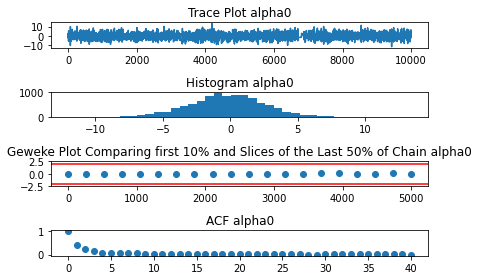

In [45]:
MCMC_diagnostics(alphas0, "alpha0") # need to thin alphas and gammas

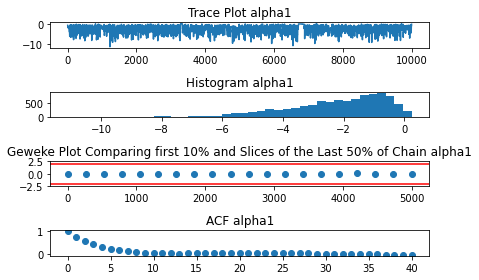

In [46]:
MCMC_diagnostics(alphas1, 'alpha1')

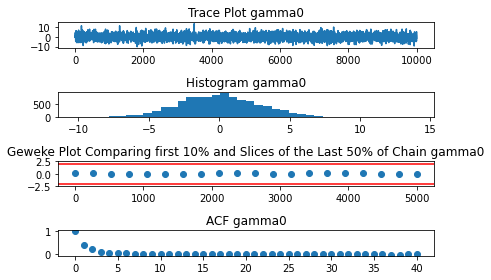

In [47]:
MCMC_diagnostics(gammas0, "gamma0")

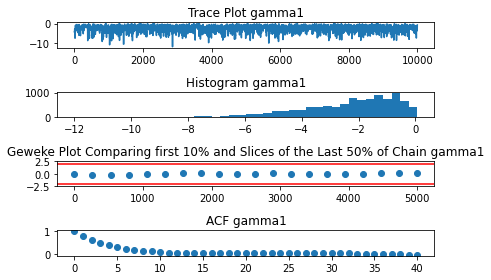

In [48]:
MCMC_diagnostics(gammas1, "gamma1")

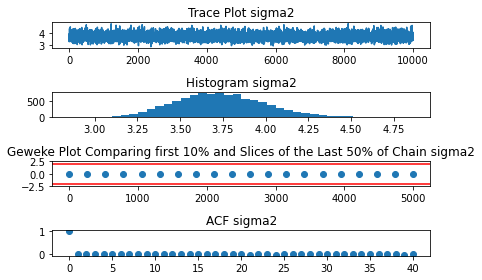

In [49]:
MCMC_diagnostics(sigmas2, "sigma2")

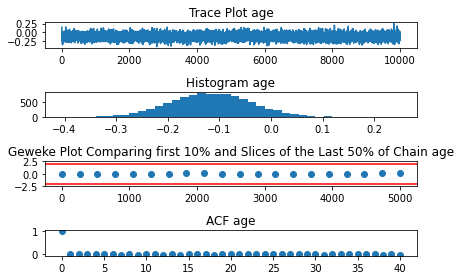

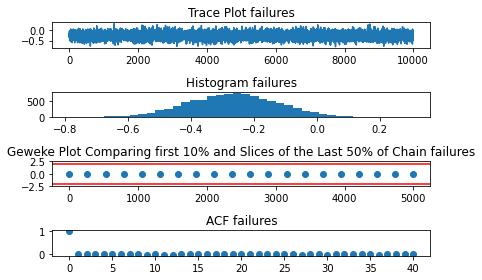

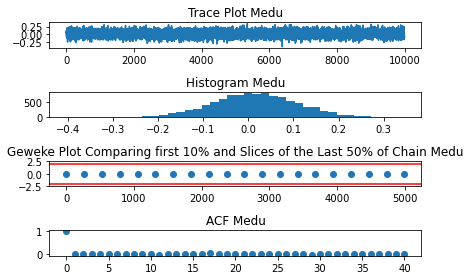

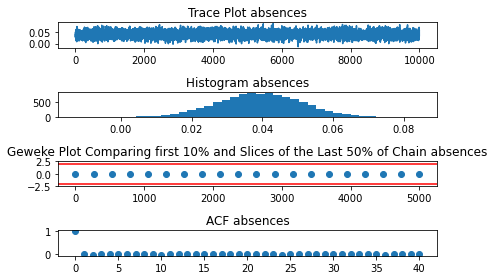

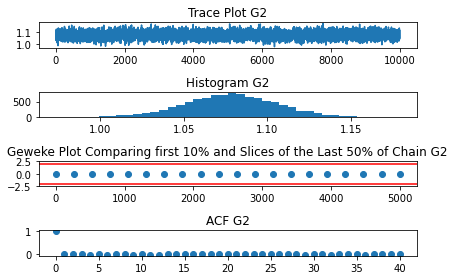

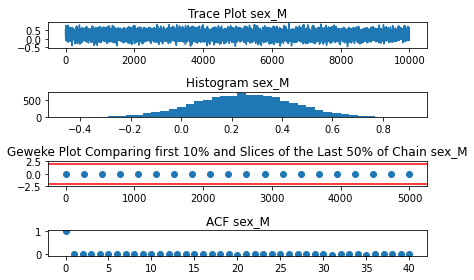

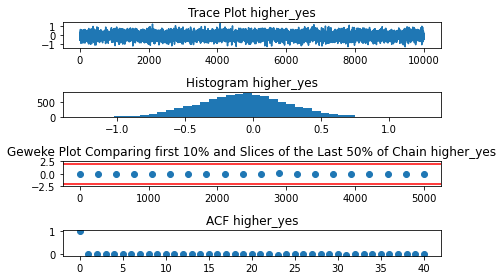

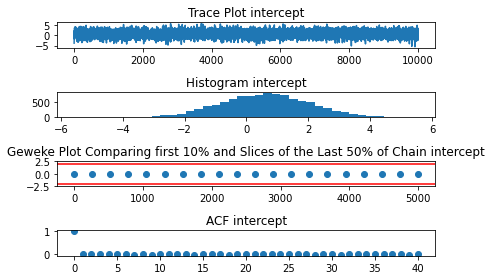

In [50]:
for i, beta in enumerate(betas):
    MCMC_diagnostics(beta, X_df.columns[i])

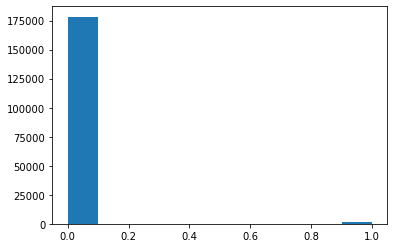

In [51]:
# simulated
# need to think of way of visualizing this
plt.hist(higher_yes_sim.flatten())
plt.show()

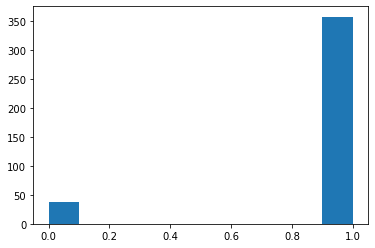

In [52]:
# observed 
plt.hist(X[:, higher_yes_col])
plt.show()

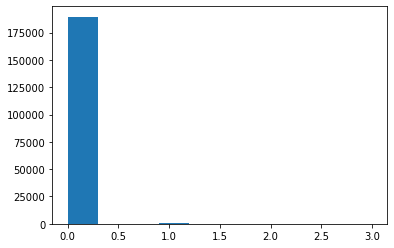

In [53]:
# simulated
plt.hist(absences_sim.flatten())
plt.show()

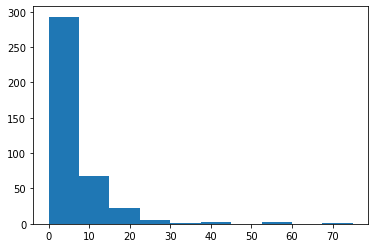

In [54]:
# oberved
plt.hist(X[:, absences_col])
plt.show()